# Comparing Different Text Vectorization Techniques in ML
### Specifically in a sentiment analysis context

#### By Alyssa Liu
#### Also available at https://github.com/alyssaliu1

In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers import concatenate

import pandas as pd
import numpy as np
import re

## Initial Data Cleaning

In [2]:
df = pd.read_csv('reviews.csv', index_col = 0)

In [3]:
df = df[['Review Text', 'Recommended IND']]
df.rename(columns={"Review Text": "Reviews", "Recommended IND": "Recommended"}, inplace = True)

In [4]:
df = df.dropna()
df.head()

,Reviews,Recommended
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


In [5]:
df["Reviews"][9]

'I\'m 5"5\' and 125 lbs. i ordered the s petite to make sure the length wasn\'t too long. i typically wear an xs regular in retailer dresses. if you\'re less busty (34b cup or smaller), a s petite will fit you perfectly (snug, but not tight). i love that i could dress it up for a party, or down for work. i love that the tulle is longer then the fabric underneath.'

In [6]:
df["Reviews"][13]

'Bought the black xs to go under the larkspur midi dress because they didn\'t bother lining the skirt portion (grrrrrrrrrrr).\r\nmy stats are 34a-28/29-36 and the xs fit very smoothly around the chest and was flowy around my lower half, so i would say it\'s running big.\r\nthe straps are very pretty and it could easily be nightwear too.\r\ni\'m 5\'6" and it came to just below my knees.'

In [7]:
import nltk
from nltk.corpus import stopwords
sw = stopwords.words('english')
sw.remove("not")
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

Notable issues for preprocessing text:
 - We can see that there are some extra characters, and sometimes \r or \n in the review text
 - Since we are essentially performing sentiment analysis (1 means the user recommends the product, which is positive sentiment, and 0 means the user does not recommend the product, which is negative sentiment), we need to be aware of what kind of stopwords we are removing, specifically when it comes to negation
     - A more specific example: "wouldn't" is removed with the NLTK stopwords library, but this would vastly change the meaning of the sentence: "I wouldn't recommend this item".

To deal with these issues, we can first remove unnecessary characters and split contractions into two words (ex: wouldn't to would + not), and then remove those words from the stopwords list.

I also noticed the dataset contained some elongated words, like "aaaaamazing", which would be processed differently than simply "amazing". We will correct those words as well.

In [8]:
def clean_reviews(review):
    new_review = re.sub(r"\'t", " not", review) # fix contractions
    new_review = re.sub(r"\'re", " are", new_review) # fix contractions
    new_review = re.sub(r"\n", "", new_review) # remove newlines
    new_review = re.sub(r"\r", "", new_review) 
    new_review = re.sub('[^a-zA-Z]', ' ', new_review) # keep only letters
    new_review = re.sub(r'\s+', ' ', new_review) # remove multiple spaces in a row
    new_review = re.sub(r"\s+[a-zA-Z]\s+", ' ', new_review) # remove characters of length < 2
    new_review = re.sub(r'(.)\1{2,}', r'\1', new_review) # remove elongated words
    new_review = new_review.strip() # remove trailing and leading whitespace
    return new_review

In [9]:
df['Reviews'] = df['Reviews'].apply(clean_reviews)

In [10]:
df['Reviews'][9]

'I and lbs ordered the petite to make sure the length wasn not too long typically wear an xs regular in retailer dresses if you are less busty cup or smaller s petite will fit you perfectly snug but not tight love that could dress it up for party or down for work love that the tulle is longer then the fabric underneath'

Now we will lemmatize the words and remove stopwords. In this case we choose lemmatization over stemming the words because the contexts of the words are important for sentiment analysis.

In [11]:
from nltk.stem import WordNetLemmatizer
def preprocess(review):
    
    # convert to lower case and split into words -> convert string into list ( 'hello world' -> ['hello', 'world'])
    words = review.lower().split()

    no_sw = []
    # lemmatizer = PorterStemmer()
    
    # remove stopwords
    for word in words:
        if word not in sw:
            no_sw.append(word)
            
        # stemm or lemmatise words
    lem_words = []
    for word in no_sw:
        lemmatizer = WordNetLemmatizer()
        word = lemmatizer.lemmatize(word, pos = "a")
        lem_words.append(word)
    
    # converting list back to string
    return " ".join(lem_words)

In [12]:
df['Reviews'] = df['Reviews'].apply(preprocess)

In [13]:
X = df['Reviews'].values
y = df['Recommended'].values

# Word Embedding Basics

### Word embedding techniques are used to map terms (or n-grams) to real-valued vectors. This is very important to bridging the gap between language and ML, as it converts text into a readable form for ML algorithms.

## Count Vectorizer

### One of the simplest word embedding techniques. For each document, we have an array, and the count of each term in the document is displayed in that array. It's great if we want to look at our text based on word frequency alone, but it's not helpful if we want to know which words are more important in our text analysis/if we want to capture context and relationships between words. It essentially just considers words that occur most frequently,

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
cvec = CountVectorizer(max_features = 3000)
cv_arr = cvec.fit_transform(X).toarray()
cv_df = pd.DataFrame(data = cv_arr, columns = cvec.get_feature_names_out())
print(cv_df.shape)
cv_df.head()

(22641, 3000)


,aa,ability,able,absolute,absolutely,abt,accent,accents,accentuate,accentuated,...,yoga,yoke,young,zero,zip,zipped,zipper,zippers,zipping,zips
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Here we can see just how massive the arrays are - we have a total of 22641 reviews (documents), each with a length of 13415 columns, which is how many unique words we have.

In [18]:
cv_Xtrain, cv_Xtest, y_train, y_test = train_test_split(cv_arr, y, test_size=0.20)


In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [21]:
nbc = MultinomialNB()
nbc.fit(cv_Xtrain, y_train)

MultinomialNB()

In [22]:
predictions = nbc.predict(cv_Xtest)

In [23]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.66      0.78      0.71       818
           1       0.95      0.91      0.93      3711

    accuracy                           0.89      4529
   macro avg       0.80      0.85      0.82      4529
weighted avg       0.90      0.89      0.89      4529



In [24]:
confusion_matrix(y_test, predictions)

array([[ 639,  179],
       [ 332, 3379]])

In [25]:
nbc.score(cv_Xtest, y_test)

0.8871715610510046

## TF-IDF

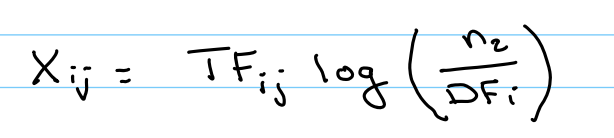

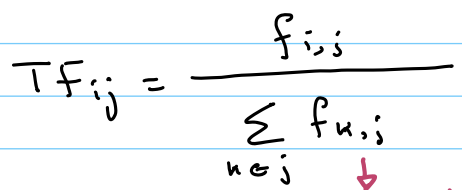

### From these photos taken from our class notes, you can see that TF-IDF is the product of term frequency (TF) and inverse-document frequency (IDF). TF is the normalized count of a word in a document, and in the displayed equation $f_{i,j}$ is the number of times term i appears in document j. All words are considered equally important for TF, so TF just gives weight to words based on how frequently they appear. IDF is the log-scaled inverse document frequency for each term. Here, $DF_{i}$ is the number of documents containing term i, showing that IDF measures and considers the importance of each term, essentially looking at the rarity of words.

### TF-IDF is great at looking at the similarities between documents, but it does not do a great job of capturing contexts of different words. 

In [26]:
from nltk.tokenize import word_tokenize

all_words = []

for review in X:
    tokenize_review = word_tokenize(review)
    for word in tokenize_review:
        all_words.append(word)

In [27]:
print(len(all_words))
print("There are " + str(len(set(all_words))) + " unique words in the review text")

654443
There are 13360 unique words in the review text


In [28]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [29]:
vectorizer = TfidfVectorizer(max_features = 3000) 
tfidf_arr = vectorizer.fit_transform(X)

In [30]:
tfidf_Xtrain, tfidf_Xtest, y_train, y_test = train_test_split(tfidf_arr, y, test_size=0.20)


In [31]:
# vectorizer.get_feature_names_out()

In [32]:
nbc = MultinomialNB()
nbc.fit(tfidf_Xtrain, y_train)

MultinomialNB()

In [33]:
predictions = nbc.predict(tfidf_Xtest)

In [34]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.27      0.41       816
           1       0.86      0.99      0.92      3713

    accuracy                           0.86      4529
   macro avg       0.86      0.63      0.66      4529
weighted avg       0.86      0.86      0.83      4529



In [35]:
nbc.score(tfidf_Xtest, y_test)

0.860454846544491

In [36]:
confusion_matrix(y_test, predictions)

array([[ 217,  599],
       [  33, 3680]])

For Not recommended reviews:
 - Out of the reviews the model predicted would not recommend an item, 97% were correct. 
 - Out of the reviews that did not recommend an item, the model predicted this outcome correctly for 27% of them.
 - The low f1-score indicates the model did a poor job of this
 
For Recommended reviews:
 - Out of the reviews the model predicted would recommend an item, 86% of them actually did. 
 - Out of the reviews that did recommend an item, the model predicted this outcome correctly for 99% of them.
 - The high f1-score indicates the model did a good job of this

When I was testing the model with different max_features parameter values, it seems that the lower the parameter value, the better the model seems to perform with predicting not recommended reviews. The score doesn't change much for the recommended reviews. 

#### It seems that our tfidf model did a good job of detecting reviews that would recommend an item, but a poor job of detecting reviews that would not recommend an item. In this case, the TF-IDF statistic seemed to be an even worse predictor than the frequency provided by count-vectorizer, which is probably why this algorithm performed even worse.

## GloVe

### GloVe, or global vectors, generates word vectors by looking at relationships between different terms within documents. It looks at both local and global statistics of terms within documents, which is why it is so powerful. This method is even more powerful than word2vec, which looks at local stats only. The idea behind the method is that we can discover more information and context by looking at words in a co-occurrence matrix, which essentially shows us the probability of seeing different words together. However, this method is not efficient, and can take up a lot of memory. It is also very time consuming because of how many parameters are involved, and it is not very easy to tune the parameters of your model because of this.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [38]:
from keras.utils import to_categorical
glove_y_train = to_categorical(y_train)
glove_y_test = to_categorical(y_test)

In [39]:
longest_sentence = max(X, key = lambda review: len(word_tokenize(review)))
length_long_sentence = len(word_tokenize(longest_sentence))
length_long_sentence # length of the longest sentence

62

In [40]:
tokenizer = Tokenizer(num_words = 13433) # num of unique words
tokenizer.fit_on_texts(X_train)

glove_X_train = tokenizer.texts_to_sequences(X_train)
glove_X_test = tokenizer.texts_to_sequences(X_test)

In [41]:
vocab_size = len(tokenizer.word_index) + 1

glove_X_train = pad_sequences(glove_X_train, padding = 'post', maxlen = length_long_sentence) # sentences must all be same length
glove_X_test = pad_sequences(glove_X_test, padding = 'post', maxlen = length_long_sentence)

### Here, we use the 100d glove embeddings from the following link: https://nlp.stanford.edu/projects/glove/. This means that the metrics and statistics from our co-occurrence matrices are being turned into 100-dimensional vectors for our neural network. We are only using 100d because this method is very inefficient and costly compared to the previous ones. 

In [42]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings = dict()

glove_file = open('glove.6B/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vec_dim = asarray(records[1:], dtype='float32')
    embeddings[word] = vec_dim

glove_file.close()

In [43]:
em_mat = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    em_vec = embeddings.get(word)
    if em_vec is not None:
        em_mat[index] = em_vec

In [44]:
from keras.optimizers import SGD

In [48]:
deep_inputs = Input(shape=(length_long_sentence, ))
em_layer = Embedding(vocab_size, 100, weights = [em_mat], trainable = False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(em_layer)
dense_layer_1 = Dense(2, activation = 'sigmoid')(LSTM_Layer_1) # sigmoid for binary classification
model = Model(inputs=  deep_inputs, outputs = dense_layer_1)
opt = SGD(learning_rate = 0.001)
model.compile(loss='binary_crossentropy', optimizer = opt, metrics=['acc'])

In [49]:
history = model.fit(glove_X_train, glove_y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
114/114 [==============================] - 14s 107ms/step - loss: 0.6850 - acc: 0.8081 - val_loss: 0.6769 - val_acc: 0.8167
Epoch 2/10
114/114 [==============================] - 13s 118ms/step - loss: 0.6694 - acc: 0.8169 - val_loss: 0.6619 - val_acc: 0.8167
Epoch 3/10
114/114 [==============================] - 13s 113ms/step - loss: 0.6550 - acc: 0.8169 - val_loss: 0.6480 - val_acc: 0.8167
Epoch 4/10
114/114 [==============================] - 11s 96ms/step - loss: 0.6415 - acc: 0.8169 - val_loss: 0.6349 - val_acc: 0.8167
Epoch 5/10
114/114 [==============================] - 12s 104ms/step - loss: 0.6288 - acc: 0.8169 - val_loss: 0.6227 - val_acc: 0.8167
Epoch 6/10
114/114 [==============================] - 12s 105ms/step - loss: 0.6169 - acc: 0.8169 - val_loss: 0.6111 - val_acc: 0.8167
Epoch 7/10
114/114 [==============================] - 13s 119ms/step - loss: 0.6056 - acc: 0.8169 - val_loss: 0.6002 - val_acc: 0.8167
Epoch 8/10
114/114 [==============================] - 15

In [50]:
score = model.evaluate(glove_X_test, glove_y_test, verbose=1)

print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

142/142 [==============================] - 4s 25ms/step - loss: 0.5660 - acc: 0.8269
Test Loss: 0.5659803152084351
Test Accuracy: 0.8268933296203613


### Our model performed more poorly than both our previous methods! Because it takes so long to rerun the model each time, it was very difficult to hypertune the parameters for this one compared to the countvectorizer and tf-idf techniques. It's likely that we would have been able to find a much higher accuracy if we had played around with the parameters a lot, but that would have been much too time-consuming.

# Overall:

### Our simplest model performed the best! Likely because that was also the method that was easiest to hypertune because of how simple and efficient it was. With a more powerful machine, and with more time, our more complex and powerful methods, especially GloVe, probably would have performed better. This was also a classification problem, so different methods may perform better with different types of problems. In addition, the text was collected from users on clothing sites, which means there may be an abundance of typos that we could not have taken care of in the data cleaning and processing stage.